<a href="https://colab.research.google.com/github/cfong32/data6100-final-proj/blob/master/data6100_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span>1</span>. Executive Summary

In this notebook, we are going to estimate the New York City Taxi Fare by Linear Regression. It used to be a competition organized by Kaggle in partnership with Google Cloud and Coursera [here](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/overview). In order to estimate it, the following steps were done.

1. The train and test data provided by Kaggle imported, cleaned and preapred for runing the model.
2. Outliers in the train set were removed based on the test set ranges.
3. Based on the RSS of the Linear Regression and Histogram-based Gradient Boosting Regression Tree in 5 folds cross validation, the final model was deployed by Histogram-based Gradient Boosting Regression Tree on all train data.


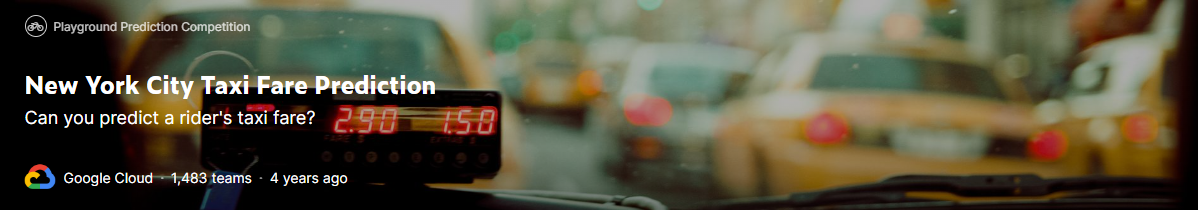

## 1.1 Kaggle Score

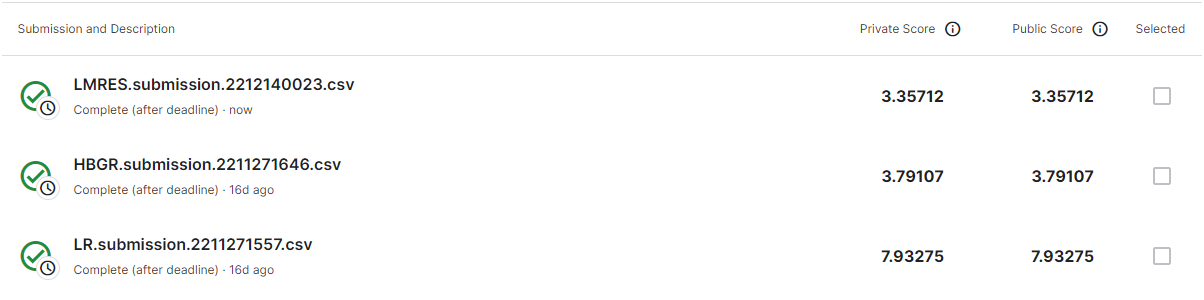

- LMRES.submission.2212140023.csv
    - Using **linear Model** to predict `'fare_amount'` by `'dist'`
    - Then using **HBGR** to predict the residual by other 9 features
        - Input features = `['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'weekday', 'hour']`
    - Combine both results
    - Using 1M training examples
    - Score: **3.35712**
- HBGR.submission.2211271646.csv
    - **Histogram-based Gradient Boosting Regression Tree**
    - Input features = `['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'weekday', 'hour', 'minute']`
    - Using 100K training examples
    - Score: **3.79107**
- LR.submission.2212271557.csv
    - **Simple linear regression**
    - Input features = `['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'weekday', 'hour', 'minute']`
    - Using 100K training examples
    - Score: **7.93275**

# <span>2</span>. Ethics



1.   Although releasing the fare prices could increase the transparency and fairness but it can cause problems like the following ones
  1.   People or drivers may compare the prices regardless of time and location and expect the same amount for the similar situation while a single condition could change the price dramatically. 
  2.   Drivers tend to go to the palces with more price. Not only it may cause a traffic in certain areas and makes the life of residents in this area difficult but also it could result in difficulties in finding a taxi in cheaper areas.
2.   If the estimation is not correct, drivers may be forced to receive less or more than what they should. The same could be true for customers.
3. Because of exact time of arrival and departure privacy of people could be jeop·ard·ized. For example, if you know your friend works in Uber and he is in the specific location at certain time, you could understand where he goes afterwards or before.
4. It could bring some security issues. For example, criminals could find routes with less traffic for escaping. Or if they know someone takes taxi regularly they could find the origin and destination and do some criminal acts.



# <span>3</span>. Exploratory Data Analysis

In [1]:
# Download dataset

!wget -q --show-progress -O new-york-city-taxi-fare-prediction.zip https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/ESnzvg-NHEhPgoURZmVYv1MBUS3GVlHGGUTbnBRS10J3Eg?download=1
!unzip -o new-york-city-taxi-fare-prediction.zip

new-york-city-taxi- 100%[===================>]   1.56G  84.3MB/s    in 18s     
Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
import pytz
from datetime import datetime, timezone
from tqdm import tqdm
import os, sys

pd.set_option('display.min_rows', 4)

## 3.1 Read Data and Augment Columns

We load and concatenate both **train** and **test** data in one dataframe so that we transform them together.  We also added some useful columns as listed in the following table.

Original          | Ours              | Description
---               | ---               | ---
fare_amount       | fare_amount       | target variable
pickup_datetime   | pickup_datetime   |
pickup_longitude  | pickup_longitude  |
pickup_latitude   | pickup_latitude   |
dropoff_longitude | dropoff_longitude |
dropoff_latitude  | dropoff_latitude  |
passenger_count   | passenger_count   |
                  | dataset           | indicating `'train'` or `'test'`
                  | year              | 2009-2015
                  | month             | 1-12
                  | weekday           | 0-6 incdicating Sun to Sat
                  | hour              | 0-23
                  | dist              | distance (km) between pickup and dropoff

In [2]:
# Helper functions

# Calculate distance between pickup and dropoff locations
def compute_dist(df):
    # source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    lat1 = df.pickup_latitude.map(np.deg2rad).values
    lon1 = df.pickup_longitude.map(np.deg2rad).values
    lat2 = df.dropoff_latitude.map(np.deg2rad).values
    lon2 = df.dropoff_longitude.map(np.deg2rad).values

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6373.0
    df['dist'] = R * c
    return df

# Load training data
def load_train_csv():
    if os.path.exists('train.55M.dfpkl'):
        df_train = pd.read_pickle('train.55M.dfpkl')
        print('data loaded from cache (train.55M.dfpkl)')
        return df_train
    else:
        chunks = pd.read_csv('train.csv',
                            nrows=20_000_000,
                            chunksize=1_000_000,
                            usecols=['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
                            engine='c',
                            )
        df_train = pd.concat([
            (chunk
            .assign(year   =lambda x: x.pickup_datetime.str[0:4].astype(int),
                    month  =lambda x: x.pickup_datetime.str[5:7].astype(int),
                    weekday=lambda x: pd.to_datetime(x.pickup_datetime.str[:10]).dt.weekday,
                    hour   =lambda x: x.pickup_datetime.str[11:13].astype(int),
                    )
            .drop(columns='pickup_datetime')
            )
            for chunk in tqdm(chunks)
        ])

        df_train.to_pickle('train.55M.dfpkl')
        print('data loaded from train.csv, also cached to train.55M.dfpkl')
        return df_train

# Load test data
def load_test_csv():
    df_test = (pd.read_csv('test.csv')
               .assign(year   =lambda x: x.pickup_datetime.str[0:4].astype(int),
                       month  =lambda x: x.pickup_datetime.str[5:7].astype(int),
                       weekday=lambda x: pd.to_datetime(x.pickup_datetime.str[:10]).dt.weekday,
                       hour   =lambda x: x.pickup_datetime.str[11:13].astype(int),
                       )
               .drop(columns='pickup_datetime')
    )
    print('data loaded from test.csv')
    return df_test

In [3]:
# Read dataset (train + test)

df = (
    pd.concat([
        (load_train_csv()
         .sample(frac=0.1)
         .assign(dataset='train')),
        (load_test_csv()
         .assign(dataset='test')),
    ])
    .pipe(compute_dist)
)

print('Number of samples')
print(f'train: {(df.dataset=="train").sum()}')
print(f'test : {(df.dataset=="test").sum()}')
display(df)

data loaded from cache (train.55M.dfpkl)
data loaded from test.csv
Number of samples
train: 5542386
test : 9914


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,dataset,key,dist
9015278,5.00,-73.982428,40.772944,-73.978608,40.764335,1,2012,11,4,13,train,NaN,1.010202
35462873,57.33,-73.983480,40.758187,-73.787340,40.646380,1,2014,11,5,16,train,NaN,20.693260
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9912,NaN,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,5,1,test,2015-01-31 01:05:19.0000005,8.346106
9913,NaN,-73.988022,40.754070,-74.000282,40.759220,6,2015,1,6,14,test,2015-01-18 14:06:23.0000006,1.181196


## 3.2 Remove Out-of-range Training Data

**Observation**

🚩 By summarizing the data per train and test dataset as below, we realize that some observations in training data are **out of range** i.e. its `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude` and `passenger_count` are outside the range of the test data.  Also, some `fare_amount` happened to be negative, which is abnormal.  **We will DROP these out-of-range data points.**

In [4]:
# Simple description of train and test data

df.groupby('dataset').describe().stack()

fare_amount  pickup_longitude  pickup_latitude  \
dataset                                                          
test    count  0.000000e+00      9.914000e+03     9.914000e+03   
        mean            NaN     -7.397472e+01     4.075104e+01   
        std             NaN      4.277395e-02     3.354146e-02   
        min             NaN     -7.425219e+01     4.057314e+01   
        25%             NaN     -7.399250e+01     4.073613e+01   
        50%             NaN     -7.398233e+01     4.075305e+01   
        75%             NaN     -7.396801e+01     4.076711e+01   
        max             NaN     -7.298653e+01     4.170956e+01   
train   count  5.542386e+06      5.542386e+06     5.542386e+06   
        mean   1.133672e+01     -7.251134e+01     3.992285e+01   
        std    9.822762e+00      1.287920e+01     9.130207e+00   
        min   -1.125600e+02     -3.439245e+03    -3.458665e+03   
        25%    6.000000e+00     -7.399206e+01     4.073495e+01   
        50%    8.500000e+00     -7.398181e+01     4.075266e+01   
        75%    1.250000e+01     -7.396710e+01     4.076713e+01   
        max    1.097480e+03      3.442185e+03     3.351468e+03   

               dropoff_longitude  dropoff_latitude  passenger_count  \
dataset                                                               
test    count       9.914000e+03      9.914000e+03     9.914000e+03   
        mean       -7.397366e+01      4.075174e+01     1.671273e+00   
        std         3.907184e-02      3.543521e-02     1.278747e+00   
        min        -7.426324e+01      4.056897e+01     1.000000e+00   
        25%        -7.399125e+01      4.073525e+01     1.000000e+00   
        50%        -7.398002e+01      4.075406e+01     1.000000e+00   
        75%        -7.396406e+01      4.076876e+01     2.000000e+00   
        max        -7.299096e+01      4.169668e+01     6.000000e+00   
train   count       5.542347e+06      5.542347e+06     5.542386e+06   
        mean       -7.251465e+01      3.991916e+01     1.685060e+00   
        std         1.289500e+01      9.540957e+00     1.331983e+00   
        min        -3.414133e+03     -3.481141e+03     0.000000e+00   
        25%        -7.399140e+01      4.073403e+01     1.000000e+00   
        50%        -7.398016e+01      4.075315e+01     1.000000e+00   
        75%        -7.396371e+01      4.076808e+01     2.000000e+00   
        max         3.442185e+03      3.390614e+03     2.080000e+02   

                       year         month       weekday          hour  \
dataset                                                                 
test    count  9.914000e+03  9.914000e+03  9.914000e+03  9.914000e+03   
        mean   2.011816e+03  6.857979e+00  2.852834e+00  1.346742e+01   
        std    1.803347e+00  3.353272e+00  1.994451e+00  6.868584e+00   
        min    2.009000e+03  1.000000e+00  0.000000e+00  0.000000e+00   
        25%    2.010000e+03  4.000000e+00  1.000000e+00  8.000000e+00   
        50%    2.012000e+03  7.000000e+00  3.000000e+00  1.500000e+01   
        75%    2.014000e+03  1.000000e+01  5.000000e+00  1.900000e+01   
        max    2.015000e+03  1.200000e+01  6.000000e+00  2.300000e+01   
train   count  5.542386e+06  5.542386e+06  5.542386e+06  5.542386e+06   
        mean   2.011739e+03  6.266529e+00  3.039502e+00  1.350977e+01   
        std    1.860095e+00  3.435504e+00  1.949063e+00  6.514207e+00   
        min    2.009000e+03  1.000000e+00  0.000000e+00  0.000000e+00   
        25%    2.010000e+03  3.000000e+00  1.000000e+00  9.000000e+00   
        50%    2.012000e+03  6.000000e+00  3.000000e+00  1.400000e+01   
        75%    2.013000e+03  9.000000e+00  5.000000e+00  1.900000e+01   
        max    2.015000e+03  1.200000e+01  6.000000e+00  2.300000e+01   

                       dist  
dataset                      
test    count  9.914000e+03  
        mean   3.436449e+00  
        std    3.973621e+00  
        min    0.000000e+00  
        25%    1.298684e+00  
        50%    2.218108

In [5]:
# Remove out-of-range training records

def remove_out_of_range_records(df):
    trainset = df.dataset == 'train'
    testset  = df.dataset == 'test'

    cols = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count']
    testset_max = df[testset][cols].max()    # max values in test set
    testset_min = df[testset][cols].min()    # min values in test set

    trainset_to_drop = (trainset
                        &
                        ((df[cols] > testset_max).any(axis=1)      # > max
                         | (df[cols] < testset_min).any(axis=1)    # < min
                         | (df['fare_amount'] < 0))                # -ve fare
                        )
    trainset_to_keep = trainset & ~trainset_to_drop

    return df[trainset_to_keep | testset]

df = remove_out_of_range_records(df)

print('Number of samples remained')
print(f'train: {(df.dataset=="train").sum()}')
print(f'test : {(df.dataset=="test").sum()}')

Number of samples remained
train: 5404324
test : 9914


## 3.3 Check if `year`, `month`, `weekday` or `hour` Matters?

**Observation**

🚩 Both `year` and `hour` have a more significant influence on the fare (per km).

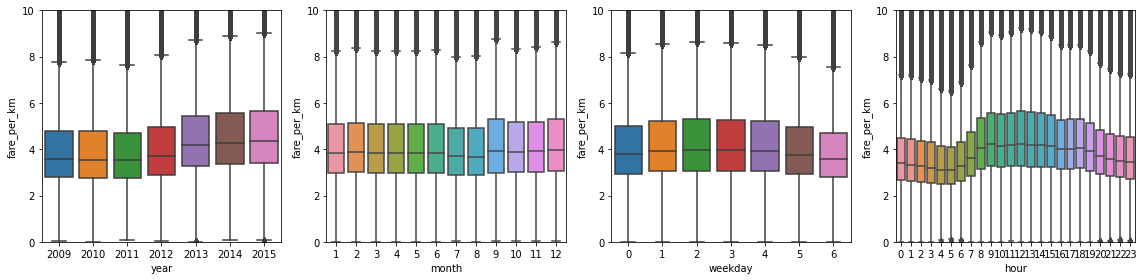

In [6]:
# Plot the fare_per_km vs time features

fig, axes = plt.subplots(1,4, figsize=(16,4))
for col, ax in zip(['year', 'month', 'weekday', 'hour'], axes.flat):
    sns.boxplot(
        data=df.assign(fare_per_km=lambda x: x.fare_amount/x.dist),
        x=col,
        y='fare_per_km',
        ax=ax,
    )
    ax.set_ylim(0,10)
plt.tight_layout()
plt.show()

## 3.4 Correlation Matrix

**Observation**

🚩 Out of all available features, `dist` correlates the most to our target variable `fare_amount`.

In [7]:
# Info of all columns

df[df.dataset=='train'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5404324 entries, 9015278 to 28424520
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fare_amount        float64
 1   pickup_longitude   float64
 2   pickup_latitude    float64
 3   dropoff_longitude  float64
 4   dropoff_latitude   float64
 5   passenger_count    int64  
 6   year               int64  
 7   month              int64  
 8   weekday            int64  
 9   hour               int64  
 10  dataset            object 
 11  key                object 
 12  dist               float64
dtypes: float64(6), int64(5), object(2)
memory usage: 577.2+ MB


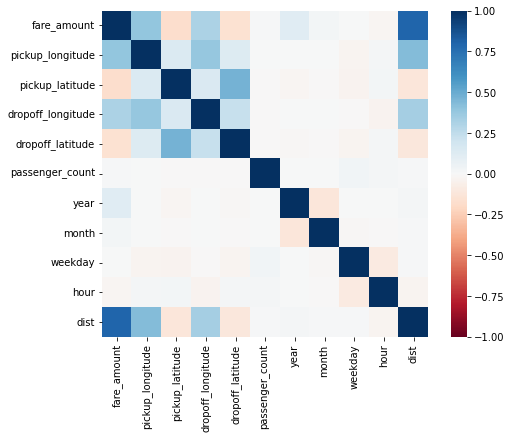

In [ ]:
# Show correlations between columns

plt.figure(figsize=(8,6))
sns.heatmap(df[df.dataset=='train'].corr(), cmap='RdBu', vmin=-1, vmax=1)
plt.gca().set_aspect('equal')
plt.show()

# <span>4</span>. Modeling

We are trying to model the $fare$ by two parts:
1. Part of the $fare$ will be predicted by a linear model (LM) which takes only $dist$ as input.
2. Residual of this linear model will then be captured by other model (RES) which takes in all other features ($X$).

\begin{align*}
\hat{fare}
    &= LM(dist) + RES(X)
\\  &= \left(\beta~dist + \gamma \right)+ RES(X)
\end{align*}

## 4.1 Training the Linear Model (LM)

We first try to train a linear model which best predict the fare by only using distance traveled, i.e.
\begin{align*}
\hat{fare}
    &= LM(dist)
\\  &= \beta~dist + \gamma
\end{align*}
where $\beta$ is the slope, and $\gamma$ is the intercept (or offset).

### 4.1.1 Data preprocessing

The preprocessing procedure is as follows,

1. Divide the dataframe to train and test datasets.
2. Remove existing outliers in train data based on the test data ranges.  This is done in previous sections.  Revomed data is %2.5 of the observations. 
3. Make sure there is no NA in the train dataset and the X and y have the same length before fitting the model.
4. Standardise the variables to treat all variables evenly.

In [8]:
# Helper function for standardizing X and y

def standardize_n_prepare_Xy(df, cols_X, col_y):
    trainset = df.dataset == 'train'
    testset  = df.dataset == 'test'

    # Make sure there is no NA
    assert df[trainset][cols_X].notna().all().all()
    assert df[trainset][col_y].notna().all().all()
    assert df[testset][cols_X].notna().all().all()
    
    # Standardize X_train and y_train
    sr_mean_X, sr_std_X = df[cols_X].mean(), df[cols_X].std()
    X_train = ((df[trainset][cols_X] - sr_mean_X) / sr_std_X).values
    y_train = df[trainset][col_y].values

    # Standardize X_test
    X_test = ((df[testset][cols_X] - sr_mean_X) / sr_std_X).values

    return X_train, y_train, X_test, sr_mean_X, sr_std_X

In [9]:
# Input and output variables

cols_X = ['dist']
col_y = 'fare_amount'
X_train, y_train, X_test, _, _ = standardize_n_prepare_Xy(df, cols_X, col_y)

X_train.shape, y_train.shape, X_test.shape

((5404324, 1), (5404324,), (9914, 1))

### 4.1.2 Training

In [10]:
# Evaluate performnace using CV

model = LinearRegression()
scores = -cross_val_score(model,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

print('5-fold cross-validation scores (RMSE):', scores)
print('Mean cross-validation score (RMSE):', np.mean(scores))

5-fold cross-validation scores (RMSE): [5.45958881 5.54695159 5.46186695 5.44953407 5.54918073]
Mean cross-validation score (RMSE): 5.493424431352122


In [11]:
# Fit a model to predict

model.fit(X_train, y_train)
y_hat = model.predict(X_train)
y_residual = y_train - y_hat

beta = model.coef_[0]
gamma = model.intercept_
print(f'Model equation:')
print(f'fare_amount = dist * {beta} + {gamma}')

Model equation:
fare_amount = dist * 7.924996249925575 + 11.315063533235497


In [12]:
# Add results (as two columns) to our dataframe

# adding the prediction as 'lm_pred'
df.loc[df.dataset=='train', 'lm_pred']     = y_hat
df.loc[df.dataset=='test' , 'lm_pred']     = model.predict(X_test)

# adding the residual as 'lm_residual'
df.loc[df.dataset=='train', 'lm_residual'] = y_residual

### 4.1.3 Interpretation

Therefore,
\begin{align*}
\hat{fare} = 7.92 ~ dist + 11.32
\end{align*}

So, from the data the model has observed that,
- the fare should on average increase \\$ 7.92 per km,
- the starting fare is effectively \\$ 11.32.

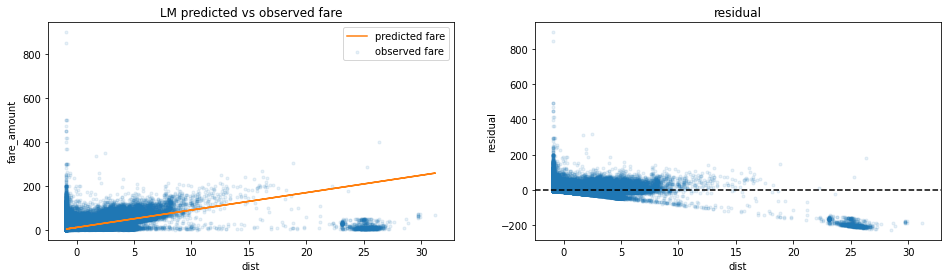

In [13]:
# Visualize performance of the linear model

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.scatter(X_train, y_train, label='observed fare', alpha=0.1, marker='.', color='C0')
ax1.plot(X_train, y_hat, label='predicted fare', color='C1')
ax1.set_title('LM predicted vs observed fare')
ax1.set_ylabel('fare_amount')
ax1.set_xlabel('dist')
ax1.legend()

ax2.scatter(X_train, y_residual, label='data', alpha=0.1, marker='.', color='C0')
ax2.axhline(0, color='k', ls='--')
ax2.set_title('residual')
ax2.set_ylabel('residual')
ax2.set_xlabel('dist')

plt.show()

**Observation**

🚩 Both `year` and `hour` are still having a clear relationship with `lm_residual`, which we are going to predict next.

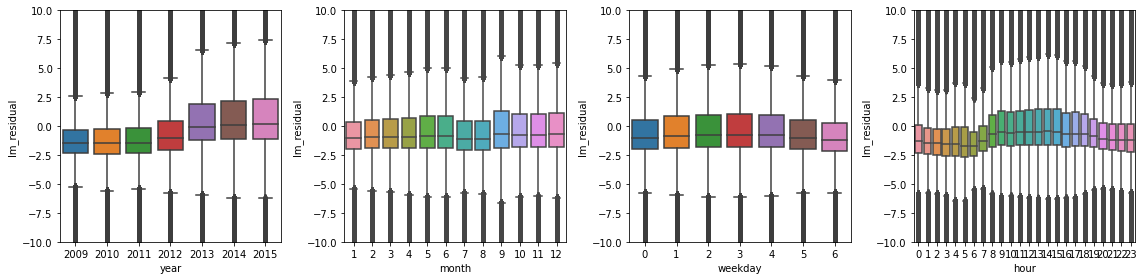

In [14]:
# Check if the residual varies with with different time features

fig, axes = plt.subplots(1,4, figsize=(16,4))
for col, ax in zip(['year', 'month', 'weekday', 'hour'], axes.flat):
    sns.boxplot(
        data=df.assign(residual_per_km=lambda x: x.lm_residual/x.dist),
        x=col,
        y='lm_residual',
        ax=ax,
    )
    ax.set_ylim(-10,10)
plt.tight_layout()
plt.show()

## 4.2 Training Residual Model (RES)

We will train a **Histogram-based Gradient Boosting Regression Tree** to model residual of the previous linear model,

\begin{align*}
\hat{residual} = RES(X)
\end{align*}

where $X$ contains 10 following features:
- `pickup_latitude`,
- `pickup_longitude`,
- `dropoff_latitude`,
- `dropoff_longitude`,
- `passenger_count`,
- `year`,
- `month`,
- `weekday`
- `hour`
- `dist`

### 4.2.1 Training

In [15]:
# Input and output variables

cols_X = [
    'pickup_latitude',
    'pickup_longitude',
    'dropoff_latitude',
    'dropoff_longitude',
    'passenger_count',
    'year',
    'month',
    'weekday',
    'hour',
    'dist',
]
col_y = 'lm_residual'
X_train, y_train, X_test, _, _ = standardize_n_prepare_Xy(df, cols_X, col_y)

X_train.shape, y_train.shape, X_test.shape

((5404324, 10), (5404324,), (9914, 10))

In [16]:
# Histogram-based Gradient Boosting Regression Tree
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor

# Evaluate performnace using CV

model = HistGradientBoostingRegressor()
scores = -cross_val_score(model,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

print('5-fold cross-validation scores:', scores)
print('Mean cross-validation score:', np.mean(scores))

5-fold cross-validation scores: [3.80498043 3.92780667 3.83560304 3.86349149 3.88510177]
Mean cross-validation score: 3.8633966769654267


In [17]:
# Fit a model to predict

model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)
y_hat = model.predict(X_train)


# Compute the overall prediction : 'overall_pred' = 'lm_pred' + 'res_pred'

df.loc[df.dataset=='train', 'res_pred'] = y_hat
df.loc[df.dataset=='test' , 'res_pred'] = model.predict(X_test)
df['overall_pred']     = df['lm_pred'] + df['res_pred']
df['overall_residual'] = df['fare_amount'] - + df['overall_pred']

In [18]:
# Evalulate the overall RMSE on the training set

df_train = df[df.dataset=='train']
true = df_train['fare_amount'].values
pred = df_train['overall_pred'].values
rmse = ((true-pred)**2).mean()**0.5

print(f'Overall RMSE: {rmse}')

Overall RMSE: 3.826015144700134


### 4.2.2 Interpretation (to be written)


#### Comparing Residual of Two Stages

**Observation**

🚩 The first linear model (**LM**) tends to over-estimate the fare.  It resulted in **a residual which biased to the negative side**.

🚩 The second gradient boosting model (**RES**) is able to fix this problem.  It adjusted the **overall residual to a more balanced distibution**.

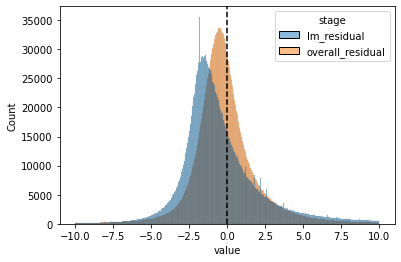

In [19]:
# Compare the distributions of residual of two stages

vmin, vmax = -10, 10
data = (df[['lm_residual', 'overall_residual']]
        .dropna()
        .rename_axis(columns='stage')
        .stack()
        .rename('value')
        .reset_index()
        .query(f'value>{vmin} and value<{vmax}')
)

sns.histplot(
    data=data,
    hue='stage',
    x='value',
)
plt.axvline(0, color='k', ls='--')
plt.show()

# <span>5</span>. Make a submission CSV

Finally, we create the CSV file based on sample submission file to submit in Kaggle.

In [20]:
import pytz
from datetime import datetime, timezone

# make submission csv
df_submission = pd.DataFrame({
    'key'        : df[df.dataset=='test']['key'],
    'fare_amount': df[df.dataset=='test']['overall_pred'],
})

timestr = datetime.now(pytz.timezone('Canada/Eastern')).strftime("%y%m%d%H%M")
save_path = f'LMRES.submission.{timestr}.csv'
df_submission.to_csv(save_path, index=False)
print('saved to', save_path)

saved to LMRES.submission.2212161249.csv


-todo
  - transforming long and lat to neighbourhood
  - Using more data in train set against limitation in colab
  - Doing Forward and Backward selections in regression
  - deploying more powerful models e.g. timeseries, KNN, Neural Network

